In [1]:
import numpy as np
import pandas as pd
import scipy.stats as spstats
from scipy import signal
import pickle
from multiprocessing import Pool
import multiprocessing
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split

from potentials import potentialRegression
from baselines import construct_ESVM_kernel,split_dataset,set_function,standartize
from optimize import Run_eval_test,optimize_parallel_new
from samplers import MCMC_sampler,Generate_train
from utils import *

## Setting parameters

<p>Datasets:</p>
<ol>
    <li>Eeg $(N=14\,980,\ d=15)$</li>
    <li>Susy $(N=500\,000,\ d=19)$</li>
</ol>

In [44]:
dataset = "eeg" # Switch between "eeg" and "susy" 

intercept = True # Do we include the intercept

CV2 = True # Do we include second-order control variates

method = {"sampler":"RWM","burn_type":"full","main_type":"full"} # Sampling method

# Switch between "posterior_prob_point", "posterior_prob_mean", "posterior_prob_variance", "posterior_mean"
f_type = "posterior_prob_mean_probit"

In [45]:
# Tuning parameters
if method["sampler"] == "ULA":
    step = 0.1
elif method["sampler"] == "MALA":
    step = 0.5
else:
    step = 0.1
    
n_traj_train = 5 # Number of independent MCMC trajectories for train
n_traj_test = 100 # Number of independent MCMC trajectories for test

if (dataset == "swiss"):
    batch_size = 1*5
    test_size = 10
    N_b = 1*10**3
    N_train = 1*10**4
    N_test = 1*10**4
elif (dataset == "eeg"):    
    batch_size = 1*15
    test_size = 100
    N_b = 1*10**3 # Burn-in period
    N_train = 1*10**4 # Length of the train trajectory
    N_test = 1*10**4 # Length of the test trajectories
elif (dataset == "pima"):
    batch_size = 1*15
    test_size = 50
    N_b = 1*10**3 #Burn-in period
    N_train = 10**4 #Length of the train trajectory
    N_test = 10**4 #Length of the test trajectory
elif (dataset == "susy"): 
    batch_size =3*19 # Batch size for stochastic gradient
    test_size = 500
    N_b = 1*10**4 # Burn in period
    N_train = 1*10**5 # Number of samples on which we optimize
    N_test = 1*10**6 # Number of samples

## Loading data

In [46]:
if (dataset == "swiss"):
    data = pd.read_csv("../iZAV_code/data/swiss.csv",header=None)
    outliers_inds = np.array([])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "eeg"):   
    data = pd.read_csv("../iZAV_code/data/eeg.csv",header=None)
    outliers_inds = np.array([13179,11509,898,10386])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "pima"):
    data = pd.read_csv("../iZAV_code/data/pima.csv",header=None)
    outliers_inds = np.array([])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "susy"): 
    data = pd.read_csv("data/susy.csv",header=None)
    outliers_inds = np.array([267630])
    Y = data.iloc[:,0]
    X = data.iloc[:,1:]

## Preprocessing data

In [47]:
# Removing the outliers
if (outliers_inds.size!=0):
    X_processed = np.delete(np.asarray(X),outliers_inds,0)
    mask = np.ones(len(Y),dtype = bool)
    mask[outliers_inds] = False
    Y_processed = Y[mask]
    Y_processed = np.asarray(Y_processed)
    X_processed = np.asarray(X_processed)
else:
    Y_processed = np.asarray(Y)
    X_processed = np.asarray(X)

In [48]:
if (f_type == "posterior_mean"):
    X_train,X_train = standartize(X_processed,X_processed,intercept=intercept)
    Y_train = Y_processed
else:
    X_train,X_test,Y_train,Y_test = train_test_split(X_processed,Y_processed,test_size=test_size,random_state=1812,stratify=Y_processed)
    X_train,X_test = standartize(X_train,X_test,intercept=intercept)

In [49]:
if (f_type == "posterior_mean"):
    X_train,X_train = standartize(X_processed,X_processed,intercept=intercept)
    Y_train = Y_processed
else:
    X_train,X_test,Y_train,Y_test = train_test_split(X_processed,Y_processed,test_size=test_size,random_state=1812,stratify=Y_processed)
    X_train,X_test = standartize(X_train,X_test,intercept=intercept)

## Creating potential

In [50]:
optim_params = {
    "compute_fp":False,
    "GD":False,
    "stochastic":False,
    "order":1,
    "n_restarts":5,
    "batch_size":100,
    "sigma":1.0,
    "gtol":1e-6,
    "gamma":5e-4,
    "weight_decay":0.995,
    "loop_length":100,
    "n_loops":300
}

In [51]:
# Construct kernel
W_train_spec = construct_ESVM_kernel(N_train)
W_test_spec = construct_ESVM_kernel(N_test)

In [52]:
# Creating potential
Cur_pot = potentialRegression(Y_train, X_train, typ = "p",optim_params = optim_params, batch_size = batch_size, print_info = True)
d = Cur_pot.d 

## Sampling training trajectories

In [53]:
if method["sampler"] == "ULA":
    res = Generate_train(n_traj_train, method, Cur_pot, step, N_b, N_train, d)
    res = np.asarray(res)
    traj,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    res = Generate_train(n_traj_train, method, Cur_pot, step, N_b, N_train, d)
    traj = []
    traj_grad = []
    for i in range(len(res)):
        traj.append(res[i][0])
        traj_grad.append(res[i][1])
        print("accepted = ",res[i][2])
    traj = np.asarray(traj)
    traj_grad = np.asarray(traj_grad)

ncores =  12
accepted =  5058
accepted =  5210
accepted =  5110
accepted =  5138
accepted =  5122


## Initialization of function values

If the function you are willing to evaluate is "posterior_prob_point" or "posterior mean" — pass through inds_arr parameter indices of variables, over which you are willing to optimize. For example, in case of "posterior_prob_point",

>inds_arr = np.array([0])

means that you are willing to reduce variance for a point from the test dataset with index $0$.

In [54]:
if (f_type == "posterior_mean"):
    inds_arr = np.array([1]) # Taking the second index (not intercept)
    params = None
else:
    params = {"X":X_test,"Y":Y_test}
    inds_arr = np.array([0])
    
f_vals = set_function(f_type,traj,inds_arr,params)

## Training coefficients for EVM and ESVM

In [55]:
n_restarts = 2 # Number of restarts during optimization
sigma = 1 # Deviation of starting points
tol = 1e-5 # Tolerance (for the norm of gradient)

In [ ]:
A_ESVM_1,A_EVM_1,A_LS_1 = optimize_parallel_new(1,inds_arr,f_vals,traj,traj_grad,W_train_spec,n_restarts,tol,sigma)
if CV2:
    A_ESVM_2,A_EVM_2,A_LS_2 = optimize_parallel_new(2,inds_arr,f_vals,traj,traj_grad,W_train_spec,n_restarts,tol,sigma)
else:
    A_ESVM_2,A_EVM_2,A_LS_2 = np.zeros((2,d**2+d)),np.zeros((2,d**2+d)),np.zeros((2,d**2+d))

1 degree optimization terminated succesfully
jacobian at termination: 
[-2.87189477e-07 -1.26688753e-06  1.43375769e-07 -1.10490987e-06
 -1.97442001e-06  2.83906019e-07 -4.65625056e-06 -3.97555212e-06
 -8.63863561e-07 -7.01193044e-07  2.52238341e-06  9.28438946e-07
  2.05145253e-06 -1.26744149e-06 -1.53613077e-06]
1 degree optimization terminated succesfully
jacobian at termination: 
[-7.01329285e-07 -1.33167686e-06 -2.11641646e-07 -1.01457368e-06
 -2.19300936e-06  1.55194437e-07 -4.01402091e-06 -3.52830199e-06
 -3.28061843e-07 -3.88527246e-07  2.13751172e-06  1.07452368e-06
  2.00946187e-06 -8.47063290e-07 -2.92228127e-07]
1 degree optimization terminated succesfully
jacobian at termination: 
[-1.29136068e-15  1.47200421e-14 -1.81724698e-14  3.12070329e-14
 -9.19409151e-15  3.05879318e-14 -4.39162283e-14 -1.78451370e-14
  1.35511421e-14  1.55291416e-14  8.09777050e-15 -9.45041029e-15
  2.35159745e-14 -2.80808698e-14  1.18498292e-14]
2 degree optimization terminated succesfully
Jacobia

  3.03920186e-07 -3.43827578e-07 -1.44213808e-07  7.13668803e-07]
2 degree optimization terminated succesfully
Jacobian matrix at termination: 
[ 2.23851889e-07  9.95101414e-07 -5.57252753e-07 -5.34612804e-07
  1.19227020e-06 -1.78295769e-06 -4.71255634e-07 -2.43034512e-07
 -4.44467310e-07 -5.31336375e-07  2.78976250e-07  1.94438350e-06
  3.88592371e-08 -7.37578489e-07  2.88680890e-08 -2.86338536e-07
 -7.17196129e-07 -4.24392898e-07  4.67584266e-08  2.36246376e-07
 -3.26571873e-07 -5.48860979e-07 -2.76680855e-07 -2.09140207e-07
  4.33328191e-07 -3.63758786e-08 -5.07739109e-07 -3.45132117e-07
  6.41257444e-08  9.42301644e-08 -7.17196129e-07  1.41999173e-08
  7.60490960e-07 -7.12271409e-07 -5.11967139e-08 -3.14904459e-07
 -1.37472910e-08 -1.70765736e-07  4.65701233e-07  7.88609713e-07
 -1.36733389e-07 -9.79488263e-08 -4.20558965e-08 -3.93012042e-08
 -4.96485189e-08 -4.24392898e-07  7.60490960e-07  2.27852725e-07
 -3.61808317e-07 -1.14802906e-07 -3.04933101e-07 -4.12848666e-07
 -1.9145803

## Coefficients for control variates

In [ ]:
print("Coefficients for ESVM")
print(A_ESVM_1)
print("Coefficients for EVM")
print(A_EVM_1)
print("Coefficients for LS")
print(A_LS_1)

Coefficients for ESVM
[[-5.18814866e-04 -3.52097493e-04 -1.42699252e-03  3.13275310e-04
  -1.09299222e-03  1.08804665e-03 -1.00227442e-03 -6.88437958e-05
  -6.57693169e-04  2.75459162e-04  6.35986767e-04  4.46415515e-04
   1.13080410e-04  6.19368445e-04 -3.54625644e-04]]
Coefficients for EVM
[[-5.20115736e-04 -3.53129329e-04 -1.42746685e-03  3.12327668e-04
  -1.09494782e-03  1.08783847e-03 -1.00543991e-03 -7.17446694e-05
  -6.58071008e-04  2.75405284e-04  6.37746066e-04  4.47398960e-04
   1.14729834e-04  6.19180804e-04 -3.54131911e-04]]
Coefficients for LS
[[ 0.0121752   0.05542425  0.05480542  0.00766135 -0.00482581  0.05438264
   0.04308023 -0.02127021  0.00874685  0.02828791  0.00925109 -0.04922236
   0.00737092 -0.0378836  -0.03178186]]


In [ ]:
if CV2:
    print("Coefficients for ESVM")
    print(A_ESVM_2)
    print("Coefficients for EVM")
    print(A_EVM_2)
    print("Coefficients for LS")
    print(A_LS_2)

Coefficients for ESVM
[[-5.38303824e-04 -3.38569303e-04 -1.50624748e-03  2.88945442e-04
  -1.12498701e-03  1.16819788e-03 -1.11463605e-03 -1.52100808e-04
  -6.33189054e-04  1.98343627e-04  6.95555175e-04  5.01645875e-04
   7.46064190e-05  6.11639231e-04 -3.89412231e-04 -7.91530550e-07
  -5.73116160e-07  3.25296048e-07  3.04412316e-08 -1.34953342e-07
  -3.04354675e-08 -5.94694981e-07 -8.26292041e-07 -2.97786684e-07
   1.07151728e-07  1.97611575e-07  3.12958636e-07 -3.56271248e-08
   2.78761723e-07 -6.75029228e-08 -5.73143101e-07 -3.38550080e-07
   7.67592411e-08  1.68317136e-07 -3.63108226e-07  9.26982948e-08
   4.77373051e-07 -1.88623227e-07  1.69627413e-07  9.09410787e-07
  -2.84488513e-08 -1.39367715e-07 -7.80718719e-08 -6.95684830e-08
  -3.98327046e-07  3.25280583e-07  7.72982473e-08 -1.12211823e-06
  -3.88598076e-07 -2.84450586e-07  8.87968998e-07 -5.15469630e-07
   1.64038470e-08  9.79214428e-08 -3.11221722e-07  4.96639208e-07
   2.56786891e-07 -1.64800481e-07 -9.88888047e-08 -6.3

## Testing EVM and ESVM

In [ ]:
# Create a dictionary, put respective matrices into it
CV_dict = {"ESVM":[A_ESVM_1,A_ESVM_2],"EVM":[A_EVM_1,A_EVM_2],"LS":[A_LS_1,A_LS_2]}
# Number of cores exploited for the computation of the independent trajectories
# by deault, all available cores on the machine
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Run_eval_test, [(i,method,inds_arr,Cur_pot,W_test_spec,CV_dict,step,N_b,N_test,d,params,f_type) for i in range (n_traj_test)])
trav.close()
res_arr = np.asarray(res) # Saving results as np.array

## Results

In [ ]:
print("Estimators")
print("Vanilla MALA {}".format(np.mean(res_arr[:,0,0,:],axis=0)))
print("ESVM pol=1 {}".format(np.mean(res_arr[:,0,1,:],axis=0)))
print("ESVM pol=2 {}".format(np.mean(res_arr[:,0,2,:],axis=0)))
print("EVM pol=1 {}".format(np.mean(res_arr[:,0,3,:],axis=0)))
print("EVM pol=2 {}".format(np.mean(res_arr[:,0,4,:],axis=0)))
print("LS pol=1 {}".format(np.mean(res_arr[:,0,3,:],axis=0)))
print("LS pol=2 {}".format(np.mean(res_arr[:,0,4,:],axis=0)))

In [ ]:
print("Variances")
print("Vanilla MALA {}".format(np.mean(res_arr[:,1,0,:],axis=0)))
print("ZAV pol=1 {}".format(np.mean(res_arr[:,1,1,:],axis=0)))
print("ZAV pol=2 {}".format(np.mean(res_arr[:,1,2,:],axis=0)))
print("ZV pol=1 {}".format(np.mean(res_arr[:,1,3,:],axis=0)))
print("ZV pol=2 {}".format(np.mean(res_arr[:,1,4,:],axis=0)))
print("LS pol=1 {}".format(np.mean(res_arr[:,1,5,:],axis=0)))
print("LS pol=2 {}".format(np.mean(res_arr[:,1,6,:],axis=0)))

In [ ]:
np.save("Logreg_determ/11_07/EEG_probit_step_1e-1_RWM_bn_10_burn_1e3_train_1e4_test_1e4.npy",res_arr)

## Plotting results

In [ ]:
var_ind = 0 # Index to plot
title = ""
labels = ['Vanilla\nULA', 'ULA\nwith EVM','ULA\nwith ESVM']

In [ ]:
# Box plot
data = [res_arr[:,0,0,var_ind],res_arr[:,0,4,var_ind],res_arr[:,0,2,var_ind]] 
boxplot_ind(data, title, labels)

In [42]:
var_ind = 0 # Index to plot
title = ""
labels = ['MALA\nwith EVM','MALA\nwith ESVM']

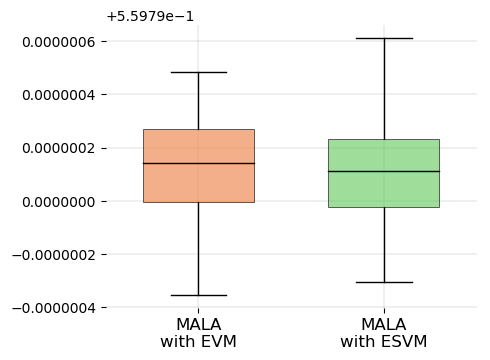

In [43]:
# Violin plots
data = [res_arr[:,0,4,var_ind],res_arr[:,0,2,var_ind]] 
boxplot_ind(data, title, labels)

In [ ]:
# Box plot
if CV2: 
    data1 = [res_arr[:,0,0,var_ind],res_arr[:,0,3,var_ind],res_arr[:,0,1,var_ind]]
    data2 = [res_arr[:,0,0,var_ind],res_arr[:,0,4,var_ind],res_arr[:,0,2,var_ind]]
    boxplot_2ind(data1, data2, title, labels)
else: 
    data = [res_arr[:,0,0,var_ind],res_arr[:,0,3,var_ind],res_arr[:,0,1,var_ind]] 
    boxplot_ind(data, title, labels)

In [20]:
results = np.load("Logreg_determ/11_07/EEG_probit_step_1e-1_RWM_bn_10_burn_1e3_train_1e4_test_1e4.npy")
print(results.shape)

(100, 2, 7, 1)


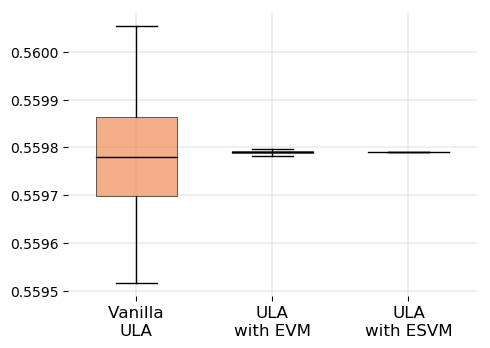

In [14]:
var_ind = 0 # Index to plot
title = ""
labels = ['Vanilla\nULA','ULA\nwith EVM','ULA\nwith ESVM']

# Violin plots
data = [results[:,0,0,var_ind],results[:,0,4,var_ind],results[:,0,2,var_ind]] 
boxplot_ind(data, title, labels)

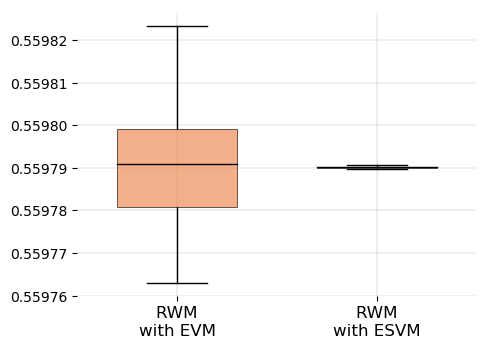

In [21]:
var_ind = 0 # Index to plot
title = ""
labels = ['RWM\nwith EVM','RWM\nwith ESVM']

# Violin plots
data = [results[:,0,4,var_ind],results[:,0,2,var_ind]] 
boxplot_ind(data, title, labels)

In [22]:
vars_vanilla = results[:,1,0,:]
vars_esvm_1st = results[:,1,1,:]
vars_esvm_2nd = results[:,1,2,:]
vars_evm_1st = results[:,1,3,:]
vars_evm_2nd = results[:,1,4,:]
print("average VRF for 1st order EVM:",np.mean(vars_vanilla)/np.mean(vars_evm_1st))
print("average VRF for 2nd order EVM:",np.mean(vars_vanilla)/np.mean(vars_evm_2nd))
print("average VRF for 1st order ESVM:",np.mean(vars_vanilla)/np.mean(vars_esvm_1st))
print("average VRF for 2nd order ESVM:",np.mean(vars_vanilla)/np.mean(vars_esvm_2nd))

average VRF for 1st order EVM: 13280.315387265673
average VRF for 2nd order EVM: 129.90534368357194
average VRF for 1st order ESVM: 13636.934634556388
average VRF for 2nd order ESVM: 529310.8547787763


In [5]:
vars_vanilla = results[:,1,0,:]
vars_esvm_1st = results[:,1,1,:]
vars_esvm_2nd = results[:,1,2,:]
vars_evm_1st = results[:,1,3,:]
vars_evm_2nd = results[:,1,4,:]
print("average VRF for 1st order EVM:",np.mean(vars_vanilla/vars_evm_1st))
print("average VRF for 2nd order EVM:",np.mean(vars_vanilla/vars_evm_2nd))
print("average VRF for 1st order ESVM:",np.mean(vars_vanilla/vars_esvm_1st))
print("average VRF for 2nd order ESVM:",np.mean(vars_vanilla/vars_esvm_2nd))

average VRF for 1st order EVM: 10430.521735751709
average VRF for 2nd order EVM: 39.45117929362206
average VRF for 1st order ESVM: 11519.21563875156
average VRF for 2nd order ESVM: 88829.55207551166
